In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import metrics
from utils import *

In [2]:
data = pd.read_csv('./601988.SH.csv')
test_set2 = data.loc[3501:, :] 
data.index = pd.to_datetime(data['trade_date'], format='%Y%m%d') 
data = data.drop(['ts_code', 'trade_date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

In [5]:
data.to_excel("./data.xlsx")

d:\code\Attention-CLX-stock-prediction\.venv\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


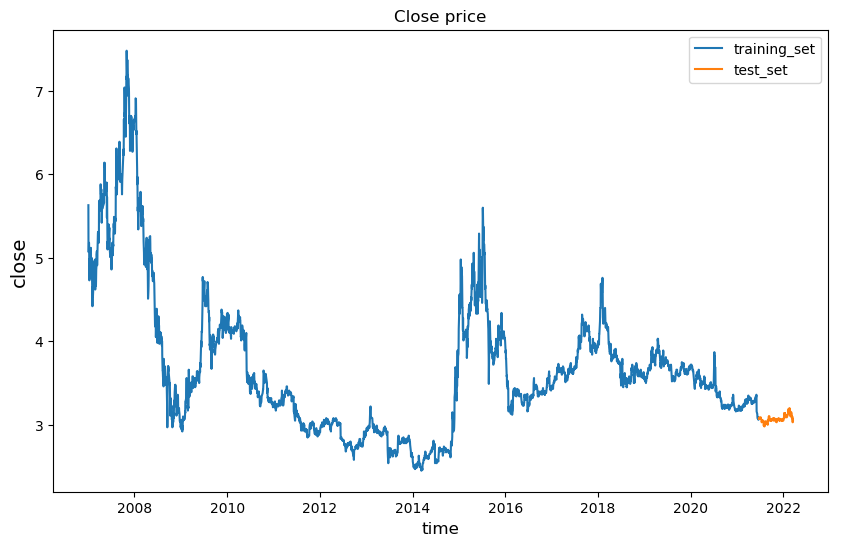

In [6]:
training_set = data.loc['2007-01-04':'2021-06-21', :]  # 3501
test_set = data.loc['2021-06-22':, :]  # 180

plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='training_set')
plt.plot(test_set['close'], label='test_set')
plt.title('Close price')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()